# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Solutions to Homework #4
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, Febrary 23rd, 2018 at 11:00am

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats 
from scipy.stats import multivariate_normal
import time
import math
from functools import partial
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

## Problem 1: Optimization (contd)

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x  + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

### Part A: Further problems with descent algorithms
Using your implementation of gradient descent and stochastic gradient descent, document the behaviour of your two algorithms for the following starting points, and for a number of stepsizes of your choice:
- $(\lambda_1, \lambda_2) = (-2.47865, 0)$
- $(\lambda_1, \lambda_2) = (-3, 0)$
- $(\lambda_1, \lambda_2) = (-5, 0)$
- $(\lambda_1, \lambda_2) = (-10, 0)$
Based on your analysis of the loss function $L$, explain what is happening to your descent algorithms.

**Solutions:** 
    
Recall that our objective function, the total (or average) loss function, looks like:
$$
\mathrm{Total Loss} = \sum_{i=1}^N L(x_i, y_i, \lambda_1, \lambda_2).
$$
In Homework #3 we explored the impact of our choice of stepsize on our various gradient descent algorithms. In this homework we explore the impact of our choice of initialization in the parameter space.

Why would your choice of initial parameters matter? Let's recall our visualization of the objective function from Homework #3:

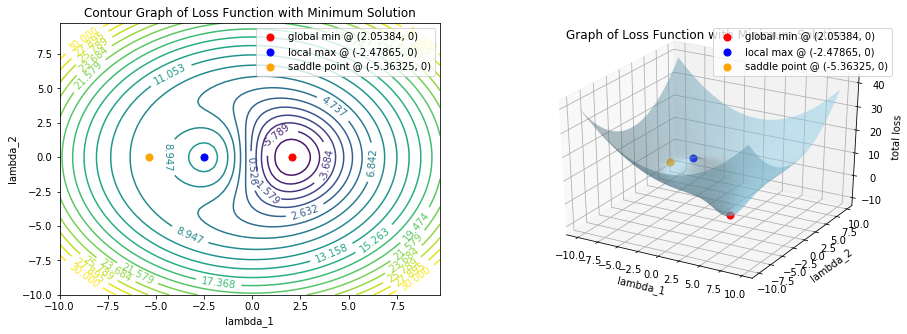

In [3]:
#Read the data
x, y = np.genfromtxt('HW3_data.csv', delimiter=',')

#Some constants we'll need
x_sum = x.sum()
y_sum = y.sum()
N = len(x)

#Total loss
L = lambda l1, l2, x, y: 0.000045 * l2**2 * y.sum() - 0.000098 * l1**2 * x.sum() + 0.003926 * x.sum() * l1 * np.exp(-0.1 * (l1**2 + l2**2))

#Cover the domain of the pdf with a grid and get the coordinates of the grid vertices
delta = 0.25
l1 = np.arange(-10, 10, delta)
l2 = np.arange(-10, 10, delta)
l1, l2 = np.meshgrid(l1, l2)
#The loss function evaluated at the vertices of the grid
loss = L(l1, l2, x, y)

fig = plt.figure(figsize=(15, 5))

#plot contour map of pdf with data in R^2 (Cartesian plane)
ax1 = fig.add_subplot(121) 
contour = ax1.contour(l1, l2, loss, levels=np.linspace(-10, 30, 20))
ax1.scatter([2.05384], [0], color='red', s=50, label='global min @ (2.05384, 0)')
ax1.scatter([-2.47865], [0], color='blue', s=50, label='local max @ (-2.47865, 0)')
ax1.scatter([-5.36325], [0], color='orange', s=50, label='saddle point @ (-5.36325, 0)')
ax1.clabel(contour, inline=1, fontsize=10)
ax1.set_title('Contour Graph of Loss Function with Minimum Solution')
ax1.set_xlabel('lambda_1')
ax1.set_ylabel('lambda_2')
ax1.legend(loc='best')

#plot 3D suface of pdf in R^3
ax2 = fig.add_subplot(122, projection='3d') 
ax2.plot_trisurf(l1.flatten(), l2.flatten(), loss.flatten(), linewidth=0.2, antialiased=True, color='skyblue', alpha=0.5, zorder=0)
ax2.scatter([2.05384], [0], [L(2.05384, 0, x, y)], color='red', s=50, label='global min @ (2.05384, 0)')
ax2.scatter([-2.47865], [0], [L(-2.47865, 0, x, y)], color='blue', s=50, label='local max @ (-2.47865, 0)')
ax2.scatter([-5.36325], [0], [L(-5.36325, 0, x, y)], color='orange', s=50, label='saddle point @ (-5.36325, 0)', zorder=10)
ax2.set_xlabel('lambda_1')
ax2.set_ylabel('lambda_2')
ax2.set_zlabel('total loss')
ax2.set_title('Graph of Loss Function with Minimum Solution')
ax2.legend(loc='best')

plt.show()

We see, from the above graphs, that our total loss function has three stationary points (points in the parameter space where the gradient of the total loss function is zero):

1. local and global minimum at approximately (2.05384, 0), with total loss -9.9341
2. local maximum at approximately (-2.47865, 0), with total loss 11.9546 
3. saddle point at approximately (-5.36325, 0), with total loss 8.16153 

At each of these points, since the gradient is very nearly zero, we'd expect gradient descent to be stationary (the algorithm will not make any updates to the parameters, since updates are proportional to the gradient vector). Thus, if gradient descent lands on either the local max or the saddle point during its path through the parameter space then it will not converge on the correct optimal value.

But how often can gradient descent get stuck at the local max or the saddle point? Since in every step of gradient descent, we update the parameter to decrease total loss, it is very unlikely that we will end up at the local max (if our initialization is not at the local max). On the other hand, if we are initialized on the left of the local max and along the straight line passing through the local max and the saddle point, then we are nearly guaranteed to land in the saddle point. The intuition is: if you initialize on the *right* side of the hill containing our local max, then we will "slide down" right into the global min, but if we initialize on the left side of the hill, then we will "slide down" into the saddle point.

Let's experiment with several initializations for gradient descent.

In [4]:
#The gradient of the total loss function
grad = lambda l1, l2, x, y: np.array([-0.000098 * 2 * l1 * x.sum() 
                                      + 0.003926 *  x.sum() * np.exp(-0.1 * (l1**2 + l2**2)) 
                                      - 0.003926 * 2 * 0.1 *  x.sum() * l1**2 * np.exp(-0.1 * (l1**2 + l2**2)), 
                                      2 * 0.000045 * l2 * y.sum() 
                                      - 0.1 * 2* 0.003926 *  x.sum() * l1 * l2 * np.exp(-0.1 * (l1**2 + l2**2))])

In [5]:
#Gradient Descent
def gradient_descent(x, y, lambdas_init, init_shuffle=False, step_size=0.001, maxsteps=None, precision=1e-3, scaling=1.):
    
    lambdas = lambdas_init
    history = [lambdas] # to store all parameters
    counter = 0

    #if you want to shuffle the data before doing descent
    if init_shuffle:
        shuffle = np.random.permutation(N)
        x = x[shuffle]
        y = y[shuffle]

    #Do descent while stopping condition not met
    while np.linalg.norm(history[-1] - np.array([2.05384, 0])) > precision:
        #get gradient of average loss function
        gradient = grad(lambdas[0], lambdas[1], x, y) * 1. / N
        #take one step in the gradient direction, scaling is just a scaling factor that adjusts the stepsize
        #of course you can just directly adjust the stepsize
        lambdas = lambdas -  step_size * gradient * scaling 
        #add our new parameters to the history
        history.append(lambdas)
        #tick off one more step
        counter +=1
        
        #if we've hit maximum steps allowed, stop!
        if maxsteps is not None:
            if counter == maxsteps:
                break
        
    return history

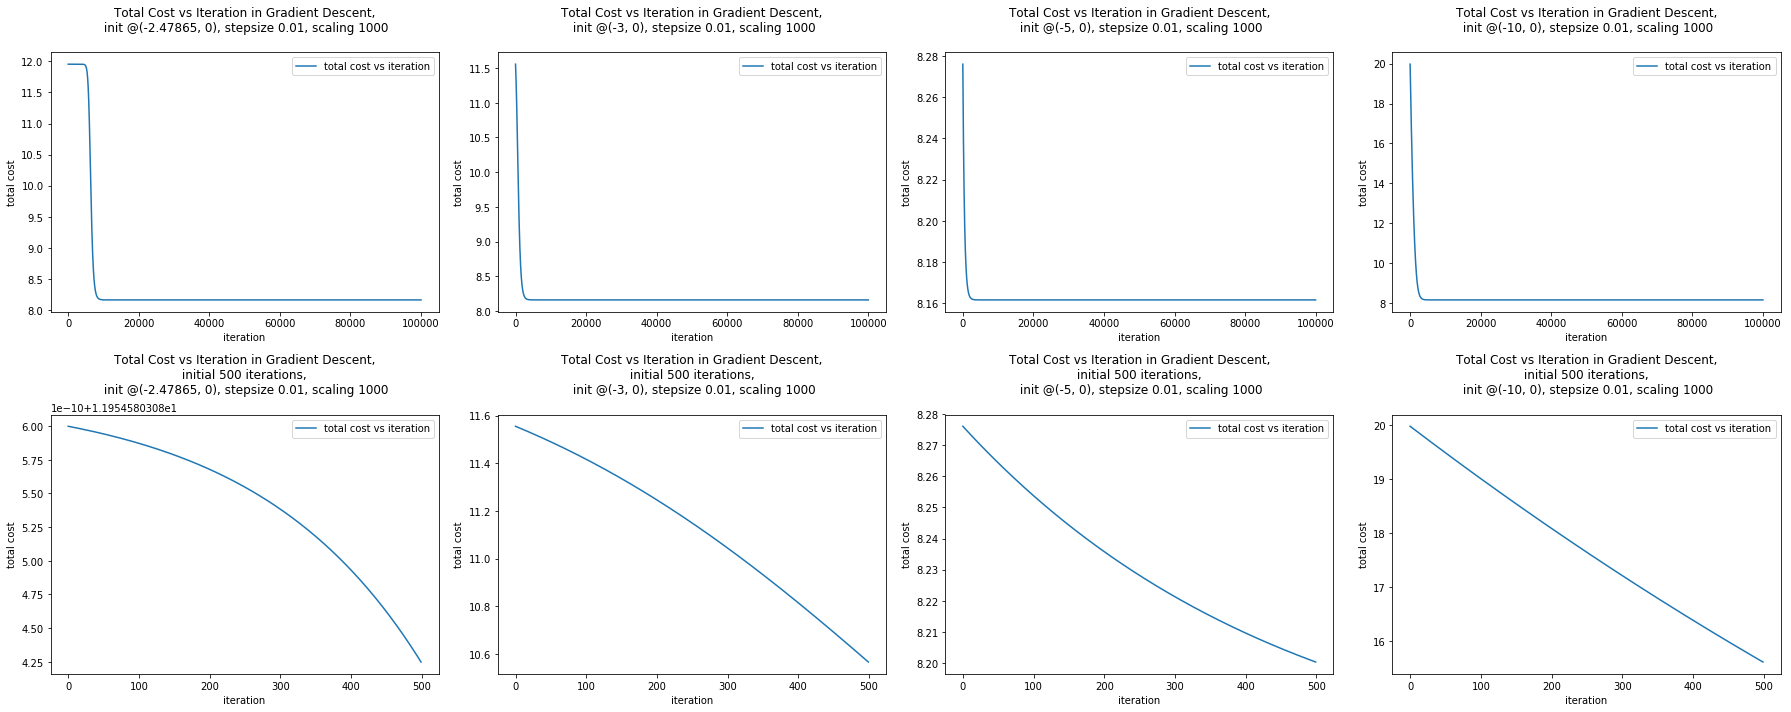

In [6]:
fig, ax = plt.subplots(2, 4, figsize=(25, 10))

lambdas_inits = [[-2.47865, 0], [-3, 0], [-5, 0], [-10, 0]]

for i in range(len(lambdas_inits)):
    history = gradient_descent(x, y, lambdas_inits[i], step_size=0.01, scaling=1000., maxsteps=100000)
    history = np.array(history)
    costs = L(history[:, 0], history[:, 1], x, y)
    ax[0, i].plot(range(len(costs)), costs, label='total cost vs iteration')
    ax[0, i].set_xlabel('iteration')
    ax[0, i].set_ylabel('total cost')
    ax[0, i].set_title('Total Cost vs Iteration in Gradient Descent,\n init @({}, 0), stepsize 0.01, scaling 1000\n'.format(lambdas_inits[i][0]))
    ax[0, i].legend(loc='best')
    
    ax[1, i].plot(range(len(costs[:500])), costs[:500], label='total cost vs iteration')
    ax[1, i].set_xlabel('iteration')
    ax[1, i].set_ylabel('total cost')
    ax[1, i].set_title('Total Cost vs Iteration in Gradient Descent,\n initial 500 iterations, \n init @({}, 0), stepsize 0.01, scaling 1000\n'.format(lambdas_inits[i][0]))
    ax[1, i].legend(loc='best')
    
plt.tight_layout()
plt.show()

We see that in each case, for each initial choice of lambdas, gradient descent proceeded towards the saddle point and, once having reached the saddle, remained at the saddle.

What is unexpected is the behaviour of gradient descent for the initialization (-2.47865, 0). Recall that at $(\lambda_1, \lambda_2) = (-2.47865, 0)$, the total loss function has a local max and at a local max the gradient is zero. So why doesn't gradient descent get stuck at the local max? Well, it did, for about a couple of thousands of iterations (see left-most column of graphs above). But recall that we are approximating the location of the local max with $(-2.47865, 0)$, thus the gradient at $(-2.47865, 0)$ is close to zero but not exactly zero. This means that your gradient descent algorithm maybe making microscopic progress in the parameter space and that if you let it run for long enough, it might move to a region of the space where the gradients are large again. Note that, in practice, we never let gradient descent algorithms crawl! That is, we terminate the algorithm whenever it ceases to make "large" updates to the parameters. This is because for a general complex objective function there is not always a way for us to predict how long the algorithm must run before it gets "unstuck" or converges on an acceptable solution. 

In [8]:
print('gradient at approximate local max (-2.47865, 0):', grad(-2.47865, 0, x, y))
print('gradient at approximate saddle (-5.36325, 0):', grad(-5.36325, 0, x, y))

gradient at approximate local max (-2.47865, 0): [  1.27466626e-05   0.00000000e+00]
gradient at approximate saddle (-5.36325, 0): [ -1.27991562e-06   0.00000000e+00]


So how will stochastic gradient descent behave around stationary points (points at which the gradient of the total loss function is zero)? Recall that stochastic gradient descent does not compute the gradient of the "real" objective function in each iteration. Rather it computes an "approximate" gradient using just one data point (i.e. it compute the gradient of the loss function at just one random point). 

In Homework #3, we discussed how this descent with "approximate" gradients can be less efficient - while gradient descent beelines for the optimal solution, stochastic gradient descent can meander in the parameter space. However, the same "noisy" trajectories stochastic gradient descent can also help us avoid getting stuck in non-optimal stationary points. The intuition is simple, at places where the total loss function has zero gradient, it is possible that a random "approximate" loss function will not have zero gradient.

Let's experiment with stochastic gradient descent for the same set of initializations in the parameter space:

In [9]:
#Stochastic Gradient Descent
def sgd(x, y, lambdas_init, init_shuffle=False, step_size=0.001, max_epochs=1, precision=1e-3, scaling=1.):
    lambdas = lambdas_init
    history = [lambdas] # to store all thetas

    counter = 0
    epochs = 0
    i = 0 #index
        
    #if you want to shuffle the data before doing descent
    if init_shuffle:
        shuffle = np.random.permutation(N)
        x = x[shuffle]
        y = y[shuffle]    
    
    #run through the data in multiple passes
    for epoch in range(max_epochs):
        #for each data point, compute the gradient and make an update to our parameters
        #print 'epoch: ', epoch 
        for i in range(N):
            #get gradient of average loss function
            gradient = grad(lambdas[0], lambdas[1], x[i], y[i])
            #take one step in the gradient direction, scaling is just a scaling factor that adjusts the stepsize
            #of course you can just directly adjust the stepsize
            lambdas = lambdas -  step_size * gradient * scaling 
            #add our new parameters to the history
            history.append(lambdas)   
            
            if np.linalg.norm(np.array(lambdas) - np.array([2.05384, 0])) < precision:
                return history, epoch
            elif np.any(np.isnan(lambdas)):
                return history[:-1], epoch
        
        #shuffle the data for the next pass thru
        shuffle = np.random.permutation(N)
        x = x[shuffle]
        y = y[shuffle]
    
    return history, max_epochs

Final cost with initialization @ (-2.47865, 0) in 8 epochs is 11.954580308623722
Final cost with initialization @ (-3, 0) in 8 epochs is 11.95458030862372
Final cost with initialization @ (-5, 0) in 8 epochs is 8.161528699372983
Final cost with initialization @ (-10, 0) in 8 epochs is 8.161528699372983


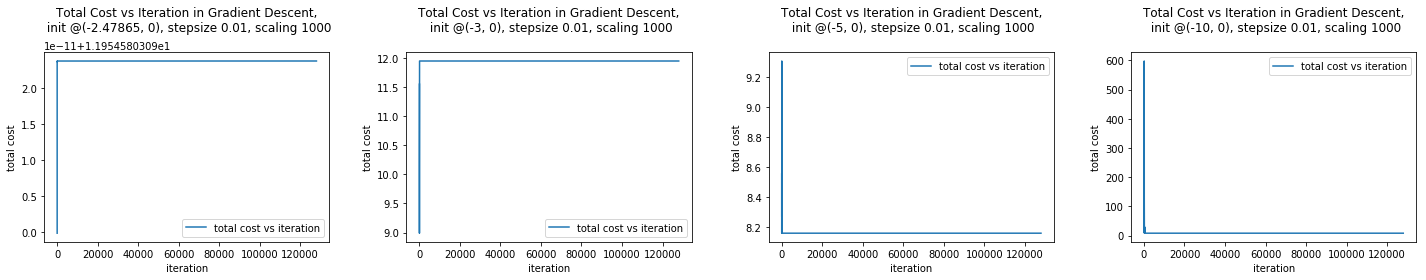

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))

lambdas_inits = [[-2.47865, 0], [-3, 0], [-5, 0], [-10, 0]]

for i in range(len(lambdas_inits)):
    history, epoch = sgd(x, y, lambdas_inits[i], init_shuffle=True, step_size=0.01, max_epochs=8, scaling=1000.)
    history = np.array(history)
    costs = L(history[:, 0], history[:, 1], x, y)
    print('Final cost with initialization @ ({}, {}) in {} epochs is {}'.format(lambdas_inits[i][0], lambdas_inits[i][1], epoch, costs[-1]))
    ax[i].plot(range(len(costs)), costs, label='total cost vs iteration')
    ax[i].set_xlabel('iteration')
    ax[i].set_ylabel('total cost')
    ax[i].set_title('Total Cost vs Iteration in Gradient Descent,\n init @({}, 0), stepsize 0.01, scaling 1000\n'.format(lambdas_inits[i][0]))
    ax[i].legend(loc='best')
    
plt.tight_layout()
plt.show()

We see that with step size 0.01 and scaling factor of 1000 (or simply step size 10), stochastic gradient descent appears to do no better than gradient descent in escaping stationary points! So is our intuition about stochastic descent wrong? Well, recall that stochastic descent is very sensitive to stepsize, in particular, the "stochastic-ness" (or randomness) of the algorithm can be either amplified or diminished by the step-size. Choose sufficiently small step sizes, you may not see too much randomness in the behaviour of your SGD; choose sufficiently large step sizes, you may observe very unexpected results.

Let's increase the step size to 0.05 with scaling factor of 1000 (or simply step size 50) and see what happens:

Final cost with initialization @ (-2.47865, 0) in 1 epochs is -9.934103808844146
Final cost with initialization @ (-3, 0) in 1 epochs is -9.934103165686881
Final cost with initialization @ (-5, 0) in 0 epochs is -9.934101688571985
Final cost with initialization @ (-10, 0) in 0 epochs is -9.934103607062502


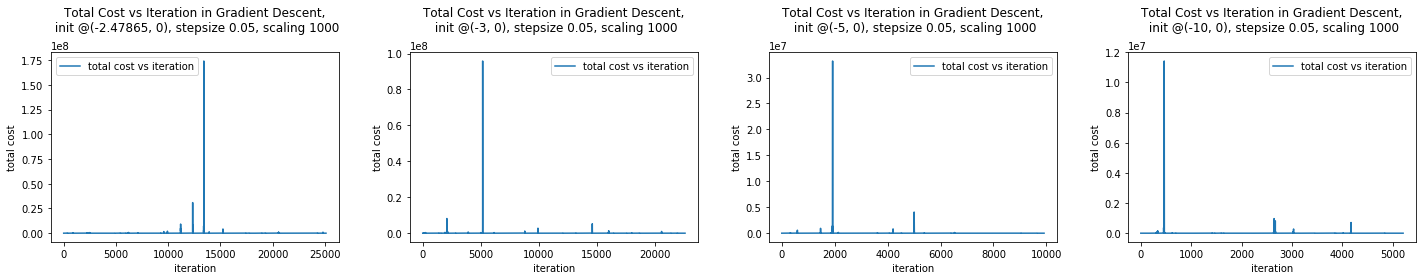

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))

lambdas_inits = [[-2.47865, 0], [-3, 0], [-5, 0], [-10, 0]]

for i in range(len(lambdas_inits)):
    history, epoch = sgd(x, y, lambdas_inits[i], init_shuffle=True, step_size=0.05, max_epochs=8, scaling=1000.)
    history = np.array(history)
    costs = L(history[:, 0], history[:, 1], x, y)
    print('Final cost with initialization @ ({}, {}) in {} epochs is {}'.format(lambdas_inits[i][0], lambdas_inits[i][1], epoch, costs[-1]))
    ax[i].plot(range(len(costs)), costs, label='total cost vs iteration')
    ax[i].set_xlabel('iteration')
    ax[i].set_ylabel('total cost')
    ax[i].set_title('Total Cost vs Iteration in Gradient Descent,\n init @({}, 0), stepsize 0.05, scaling 1000\n'.format(lambdas_inits[i][0]))
    ax[i].legend(loc='best')
    
plt.tight_layout()
plt.show()

So in this case, we see that SGD is able to converge onto the correct optimum for all initial values of lambdas we chose! With an increase in the step size, we were able to amplify the randomness of the algorithm enough to help us escape stationary points! 

Now, this begs the question:

**What step size should I choose to help SGD escape undesirable stationary points?**

For example, is it true that the bigger the step-size the faster my SGD algorithm converges onto the global minimum? Let's run SGD on the same set of initial lambda values again, this time, with step size 0.5 and scaling factor 1000 (or step size 500).

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))

lambdas_inits = [[-2.47865, 0], [-3, 0], [-5, 0], [-10, 0]]

for i in range(len(lambdas_inits)):
    history, epoch = sgd(x, y, lambdas_inits[i], init_shuffle=True, step_size=0.5, max_epochs=8, scaling=1000.)
    history = np.array(history)
    costs = L(history[:, 0], history[:, 1], x, y)
    print('Final cost with initialization @ ({}, {}) in {} epochs is {}'.format(lambdas_inits[i][0], lambdas_inits[i][1], epoch, costs[-1]))
    ax[i].plot(range(len(costs)), costs, label='total cost vs iteration')
    ax[i].set_xlabel('iteration')
    ax[i].set_ylabel('total cost')
    ax[i].set_title('Total Cost vs Iteration in Gradient Descent,\n init @({}, 0), stepsize 0.5, scaling 1000\n'.format(lambdas_inits[i][0]))
    ax[i].legend(loc='best')
    
plt.tight_layout()
plt.show()

Just as we saw in Homework #3, when the step size is "large", stochastic gradient descent can have unexpected and deeply undesirable behaviours (for contrast, run gradient descent using a 0.5 step size).

### Lesson Learned:
Unlike gradient descent, which can get stuck in undesirable stationary points, the randomness of stochastic gradient descent can keep the algorithm moving towards the global optimum. But this benefit can only be realized by the correct choice of step size, for a choice of step size that is too small, the randomness of SGD (with fixed step size) is insufficient to move it out of a stationary point; for a choice of step size that is too large, the randomness of SGD (with fixed step size) may prevent the algorithm from converging or even getting close to the global optimum.

## Problem 2: Logistic Regression and MNIST (contd)




The MNIST dataset is one of the classic datasets in Machine Learning and is often one of the first datasets against which new classification algorithms test themselves. It consists of 70,000 images of handwritten digits, each of which is 28x28 pixels. 

Last time you used PyTorch to build a handwritten digit multi-class logistic regression classifier that you trained and tested with MNIST dataset.

We'll introduce validation sets and regularization in this problem.

Using the softmax formulation, write a PyTorch model that computes the cost function using an L2 regularization approach (see `optim.SGD` in PyTorch or write your own cost function) and minimizes the resulting cost function using mini-batch stochastic gradient descent.

Construct and train your classifier using a batch size of 256 examples, a learning rate η=0.1, and a regularization factor λ=0.01.

1. Using classification accuracy, evaluate how well your model is performing on the validation set at the end of each epoch. Plot this validation accuracy as the model trains. 
2. Duplicate this plot for some other values of the regularization parameter $\lambda$. When should you stop the training for different values of λ? Give an approximate answer supported by using the plots.
3. Select what you consider the best regularization parameter and predict the labels of the test set. Compare with the given labels. What classification accuracy do you obtain on the test set?

**Solutions:**

We've already substantially approached this problem in HW3.  The main things that we are adding in this incarnation of the problem are a validation set (so as not to commit the sin of using the training set as a validation set) and regularization.  What we noticed in HW3 is that the test set performance for our Logistic Regression Models were in line with the training set performance -- both in the 89-92% range. Given this turn of events, we would not expect our models to have been plagued by overfitting and it would thus be somewhat surprising for a regularization parameter to affect our accuracies.  Let's see how our experimental results line up against our expectations.

First of all -- let's update our class from HW3.

In [2]:
## Standard boilerplate to import torch and torch related modules
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
# Regression Parent Class
class Regression(object):
    
    def __init__(self):
        self.params = dict()
    
    def get_params(self, k):
        return self.params.get(k, None)
    
    def set_params(self, **kwargs):
        for k,v in kwargs.items():
            self.params[k] = v
        
                    
    def fit(self, X, y):
        raise NotImplementedError()
        
    def predict(self, X):
        raise NotImplementedError()
        
    def score(self, X, y):
        raise NotImplementedError()
        

In [4]:
## Our PyTorch implementation of Logistic Regression
class LRPyTorch(nn.Module):

    ## the constructor is where we'll define all our layers (input, hidden, and output)
    def __init__(self):

        ## this line creates an instance of our parent (or base) class which in this case
        ## is nn.Module.
        super().__init__()

        ## in the lines below we'll create instance variables and assign them torch.nn Models
        ## in order to create our layers.  You should ordinarily have one variable definition for each layer
        ## in your neural network except for the output layer.  The output layer is defined by the number of
        ## outputs in your last layer. Since we're dealing with simple Artificial Neural Networks, we should
        ## predominantly be using nn.Linear.  
        self.l1 = nn.Linear(784, 10)

 
    # forwards takes as a parameter x -- the batch of inputs that we want to feed into our neural network model
    # and returns the output of the model ... i.e. the results of the output layer of the model after forward
    # propagation through our model. practically this means you should call each layer you defined in the
    # constructor in sequence plus any activation functions on each layer.
    def forward(self, x):
     
        # call all our layers on our input (in this case we only need one)
        x = self.l1(x)

        # Since we're using Cross Entropy Loss
        # we can return our output directly
        return x


In [13]:

class Artificial_Neural_Network(Regression):
    
    def __init__(self, input_model, reg_rate = 0.01, learning_rate=0.1, batch_size=256, epochs=30, hidden=None):
        
        super().__init__()
        
        
        ## Load MNIST Data
        train_dataset, test_dataset, train_loader, test_loader, validation_loader, train_idx, validation_idx = self.load_data(batch_size=batch_size)
        
        ## Add Datasets and Data Loaders to our params
        self.set_params(train_dataset=train_dataset, 
                        train_loader=train_loader,
                        test_dataset=test_dataset,
                        test_loader=test_loader,
                        validation_loader=validation_loader,
                        train_idx=train_idx,
                        validation_idx=validation_idx
                       )
        
        
        ## Here we instantiate the PyTorch model that we so nicely defined previously
        if hidden == None:
            model = input_model()
        else:
            model = input_model(hidden=hidden)

        ## Here we define our loss function.  We're using CrossEntropyLoss but other options include
        ## NLLLoss (negative log likelihood loss for when the log_softmax activation is explicitly defined
        ## on the output layer), MSELoss for OLS Regression, KLLDivLoss for KL Divergence, BCELoss
        ## for binary cross entropy and many others
        criterion = nn.CrossEntropyLoss()

        ## Here we define our optimizer.  In class we've been using SGD although in practice one will often
        ## use other optimizers like Adam or RMSProp.  The primary parameter the optimizer takes is the
        ## set of parameters in your model.  Fortunately those are easily accessible via model.paramters()
        ## where model is the instance of the model you defined.  Other useful parameters include lr for the
        ## learning rate and weight_decay for the rate of l2 regularization.
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.01)
        
        
        ## Set the rest of our parameters -- batch_size, learning_rate, epochs, optimizer,
        ## model and criterion
        
        ## Add Datasets and Data Loaders to our params
        self.set_params(optimizer=optimizer, 
                        learning_rate=learning_rate,
                        batch_size=batch_size,
                        model=model,
                        criterion=criterion,
                        epochs=epochs)   
        
    def load_data(self, validation_split=10000, batch_size=256):
        """load the MNIST training and test sets from MNIST"""
        
        
        ## We start by defining our training dataset
        ## --root-- a string pointing to the relative path of the directory where we'll store our MNIST data
        ## --train-- tells us whether to download the training set (True) or the test set (False)
        ## MNIST in torchvision only has train (60K) and test (10K) datasets.  Other datasets also have a validation set
        ## --transforms-- is a torchvision.transforms object that specifies what transforms to apply to each element
        ## in the dataset.  The required transform is transforms.ToTensor() that turns each element into a PyTorch floating
        ## point tensor object.  You could also add others like transforms.Normalize if you wished
        ## --download-- specifies whether to download the data from the online urls.   If set to false, then you should
        ## provide the data locally yourself
        train_dataset = datasets.MNIST(root='./hw3_data',
                                    train=True,
                                    transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)),
                                     ]),
                                    download=True)

        ## similar to the above, the main difference is that we should set train=False since we want the

        ## test set data
        test_dataset = datasets.MNIST(root='./hw3_data',
                                   train=False,
                                   transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)),
                                     ]),
                                   download=True)

        ## A DataLoader or (Dataset Loader) turns the specified data set into a sequence of data elements
        ## that you can access in your loops for training or evaluating accuracy, etc.

        ## First we need to further split our training dataset into training and validation sets.

        # Define the indices
        indices = list(range(len(train_dataset))) # start with all the indices in training set

        # Define your batch_size
        batch_size = batch_size

        # Random, non-contiguous split
        validation_idx = np.random.choice(indices, size=validation_split, replace=False)
        train_idx = list(set(indices) - set(validation_idx))

        # define our samplers -- we use a SubsetRandomSampler because it will return
        # a random subset of the split defined by the given indices without replacement
        train_sampler = SubsetRandomSampler(train_idx)
        validation_sampler = SubsetRandomSampler(validation_idx)

        # Create the train_loader -- use your real batch_size which you
        # I hope have defined somewhere above
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                        batch_size=batch_size, sampler=train_sampler)

        # You can use your above batch_size or just set it to 1 here.  Your validation
        # operations shouldn't be computationally intensive or require batching.
        validation_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                        batch_size=validation_split, sampler=validation_sampler)

        test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                  batch_size=len(test_dataset),
                                                  shuffle=False)

        return (train_dataset, test_dataset, 
                train_loader, test_loader, 
                validation_loader,
                train_idx, validation_idx
               )
    
    def sample_training_images(self):
        """Create a set of sample images from the MNIST training images"""
        
        training_set = self.get_params('train_dataset')
        train_idx = self.get_params('train_idx')
        sample_indices = np.random.choice(train_idx, 10)
        
        sample_images = training_set.train_data[sample_indices,:,:].numpy()
        sample_labels = [training_set.train_labels[x] for x in sample_indices]
        
        self.set_params(sample_training_images=sample_images)
        self.set_params(sample_training_labels=sample_labels)
        
    def save_misclassified(self, predictions, images, labels):
        """Create and save a set of sample images misclassified images by the model"""
             
        sample_indices = np.random.choice(range(len(predictions)), 10)
        
        sample_images = [images[x].reshape(28,28) for x in sample_indices]
        sample_labels = [predictions[x] for x in sample_indices]
        true_labels = [labels[x] for x in sample_indices]

        ## save the random samples -- images, labels, ground_truth
        self.set_params(misclassified_images=sample_images)
        self.set_params(misclassified_labels=sample_labels)
        self.set_params(misclassified_true_labels=true_labels)
        
        ## save all the misclassified predictions and labels
        self.set_params(all_missed_labels=predictions)
        self.set_params(all_missed_true_labels=labels)
        
        
        
        
    def viz_training_images(self):
        """Visualize/Plot sample training images"""
        
        if not self.get_params('training_labels'):
            self.sample_training_images()
        
        # get the images and labels
        sample_images = self.get_params("sample_training_images")
        sample_labels = self.get_params("sample_training_labels")
        
        fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 10))
        plt.suptitle("Some Sample Images from MNIST", fontsize=20, weight='heavy')

        for i in range(5):
            ax1[i].imshow(sample_images[i])
            ax1[i].set_title("MNIST Label: {}".format(sample_labels[i]))
            ax2[i].imshow(sample_images[i+5])
            ax2[i].set_title("MNIST Label: {}".format(sample_labels[i+5]), weight='bold')
            
        plt.show()

    def viz_misclassified_images(self):
        """Visualize/Plot misclassified training images"""

        # get the images and labels
        sample_images = self.get_params("misclassified_images")
        sample_labels = self.get_params("misclassified_labels")
        true_labels = self.get_params("misclassified_true_labels")

        if not sample_labels:
            raise(Exception("Please run predict() or score() with save_misclassified=True"))

        fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 10))
        plt.suptitle("Some Sample Misclassified Images", fontsize=20, weight='heavy')

        for i in range(5):
            ax1[i].imshow(sample_images[i])
            ax1[i].set_title("MNIST Label: {} Classified: {}".format(true_labels[i], sample_labels[i]), weight='bold')
            ax2[i].imshow(sample_images[i+5])
            ax2[i].set_title("MNIST Label: {} Classified: {}".format(true_labels[i+5], sample_labels[i+5]), weight='bold')

        plt.show()
        
    
    ## Stolen from excellent visualization from submission from Madeleine Duran/Sarah Walker
    def viz_training_loss(self, epochs=30):
        """Visualize/Plot our training loss"""
        
        losses = self.get_params("training_losses")
        
        if type(losses) == type(None):
            raise("Please run fit() to train data")
        
        fig, axes = plt.subplots(nrows=1, ncols=epochs, figsize=(20,5), sharex=True, sharey=True)
        plt.suptitle("Loss Trajectory for MNIST LR Model", fontsize=20, weight='heavy')
        
        for i in range(epochs):
            axes[i].plot(range(len(losses[i])), losses[i])
            axes[i].set_title("epoch {}".format(i))
            if i % 2 == 1:
                axes[i].axvspan(0, len(losses[i]), facecolor='gray', alpha=0.2)
        plt.subplots_adjust(wspace=0)
        plt.show()
        
    def get_loader(self, dataset):
        """Retrieve dataloader, images, labels based upon dataset name"""
        
        if dataset == 'Test':
            loader = self.get_params('test_loader')
        elif dataset == 'Validation':
            loader = self.get_params('validation_loader')
        else:
            loader = self.get_params('train_loader')
            
        # Get Loader
        return loader
    
    def predict(self, dataset='Test', save_misclassified=True):
        """Classify images based on the fitted logistic regression model"""

        loader = self.get_loader(dataset)
        
        predictions = []
        all_labels = []
        misclassified = []
        misclassified_images = []
        misclassified_labels = []
        misclassified_preds = np.array([])
        correct = 0
        model = self.get_params('model')

        for inputs, labels in loader:

            ## get the inputs from the dataloader and turn into a variable for 
            ## feeding to the model
            inputs = Variable(inputs)

            ## Reshape so that batches work properly
            inputs = inputs.view(-1, 28*28)

            # run our model on the inputs
            outputs = model(inputs)

            # get the class of the max log-probability
            pred = outputs.data.max(1)[1]
            
            # get the correct predictions
            correct += (pred == labels).sum()

            # save current batch of predictions
            predictions += list(pred)
            
            # save all labels
            all_labels += list(labels)
            
            if save_misclassified:
                
                # keep track of the misclassified labels, images, and prediction
                missed = (pred != labels)
                missed_labels = labels[missed]
                images = inputs.data.numpy()
                missed_images = [images[index] for index,value in enumerate(missed) if value==True]

                misclassified_labels = np.append(misclassified_labels, missed_labels)
                misclassified_images += missed_images
                misclassified_preds = np.append(misclassified_preds, pred[missed])
                
                            
            
        self.set_params(predictions=predictions, 
                        correct_predictions=correct,
                        prediction_dataset_length=len(predictions),
                        all_labels=all_labels
                       )
        
        # Save misclassified images/predictions/labels for visualizing later
        if save_misclassified:
            self.save_misclassified(misclassified_preds, misclassified_images, misclassified_labels,)
            
        return np.array(predictions)
    
    
    def score(self, dataset='Test', print_score=True, save_misclassified=True ):
        """Calculate accuracy score based upon model classification"""
        
        self.predict(dataset=dataset, save_misclassified=save_misclassified)
        correct = self.get_params('correct_predictions')
        total = self.get_params('prediction_dataset_length')
        
        if print_score:
            print('Dataset: {} \nAccuracy: {}/{} ({:.1f}%)\n'.format(
                dataset, correct, total, 100.0 * correct / total))
        
        return(correct/total)
    
    
    def missed_number(self, number):
        """Calculate accuracy for a certain true label"""
        
        labels = np.array(self.get_params("all_labels"))
        predictions = np.array(self.get_params("predictions"))
        missed = np.array(self.get_params("all_missed_true_labels"))
        
        total_number = len(labels[labels == number])
        missed_number = len(missed[missed == number])
        
        return(1-missed_number/total_number)
    
    
    def generate_missed_percentages(self):    
        for i in range(10):
            print("Label: {} -- Accuracy: {}".format(i, 100*self.missed_number(i)))
               
        
    def fit(self, do_validation=True, show_validation=True):
        """Fit our logistic regression model on MNIST training set"""
        
        ## We defined a number of variables in our constructor -- let's reclaim them here
        optimizer=self.get_params("optimizer")
        model=self.get_params("model")
        epochs=self.get_params("epochs")
        criterion=self.get_params("criterion")
        train_loader=self.get_params("train_loader")
        
        ## Get the Total size of training set
        self.get_params('train_dataset')
        training_size = len(self.get_params('train_idx'))
        
        iterations = int(np.ceil(training_size/self.get_params("batch_size")))
        
        ## We need something to keep track of our losses
        losses = np.zeros((epochs, iterations))
        
        ## We need something ot keep track of our validation scores
        validation_scores = np.zeros(epochs)
  
        
        ## Our training loop.  We can loop over a fixed number of epochs or
        ## using a sensitivity parameter (i.e. until net change in loss is
        ## below a certain tolerance).  Here we iterate over a fixed number of
        ## epochs
        for epoch in range(epochs):

            ## We defined our train_loader DataLoader earlier.  The train_loader is a
            ## sequence of tuples with the first element of each tuple being
            ## the batched training inputs (the batch_size being defined in your DataLoader)
            ## and the second second element of each tuple being the corresponding labels
            ## more or less all the pytorch classes are built to handle batching transparently

            ## loop through the DataLoader.  Each loop is one iteration.  All the loops
            ## form one epoch
            for batch_index, (inputs, labels) in enumerate(train_loader):

                # Convert the inputs/labels passed from the DataLoader into
                # autograd Variables.  The dataloader provides them as PyTorch Tensors
                # per the transforms.ToTensor() operation.
                inputs, labels = Variable(inputs), Variable(labels)

                ## as mentioned above we receive the inputs as tensors of size (batch_size,1, 28, 28)
                ## which is effectively (batch_size, 28, 28) basically as a 3 dimensional tensor
                ## representing a stack of (28x28) matrices with each matrix element a floating point number
                ## representing the value of that pixel in the image.  Unfortunately our Neural Network model
                ## can't handle that representation and needs a pixel matrices to be flattened into a row vector
                ## of inputs.  The model takes a 2d tensor representing batch of such row vectors each row vector
                ## representing one set of inputs corresponding to one image.  In order to accomplish this
                ## flattening we use the .view method defined on autograd Variables.
                inputs = inputs.view(-1, 28*28)

                # we need to zero out our gradients after each pass
                optimizer.zero_grad()


                ## This is the optimize - forward step - backwards step part of our design pattern

                # this is the forward step --> we calculate the new outputs based upon the input data from
                # this batch and store the outputs in a variable
                outputs = model(inputs)

                # we compare the outputs to the ground truth labels in the batch to calculate the loss for this step
                loss = criterion(outputs, labels)
                
                ## count the loss
                losses[epoch,batch_index] = loss.data[0]

                # we run backpropagation on the loss variable which repopulates the gradients all the way
                # back through our model to the input layer
                loss.backward()

                # Use the gradients calculated in the backprop that took place in .backwards() to do a new
                # gradient descent step
                optimizer.step()
            
            ## After each epoch -- we should test validation accuracy
            if do_validation:
                if show_validation: print("Epoch: ", epoch)
                validation_scores[epoch] = self.score("Validation", print_score=show_validation, save_misclassified=False)
            
                
        ## Set Loss Matrix for visualizing
        self.set_params(training_losses=losses)
        self.set_params(validation_scores=validation_scores)
        
        return self
        

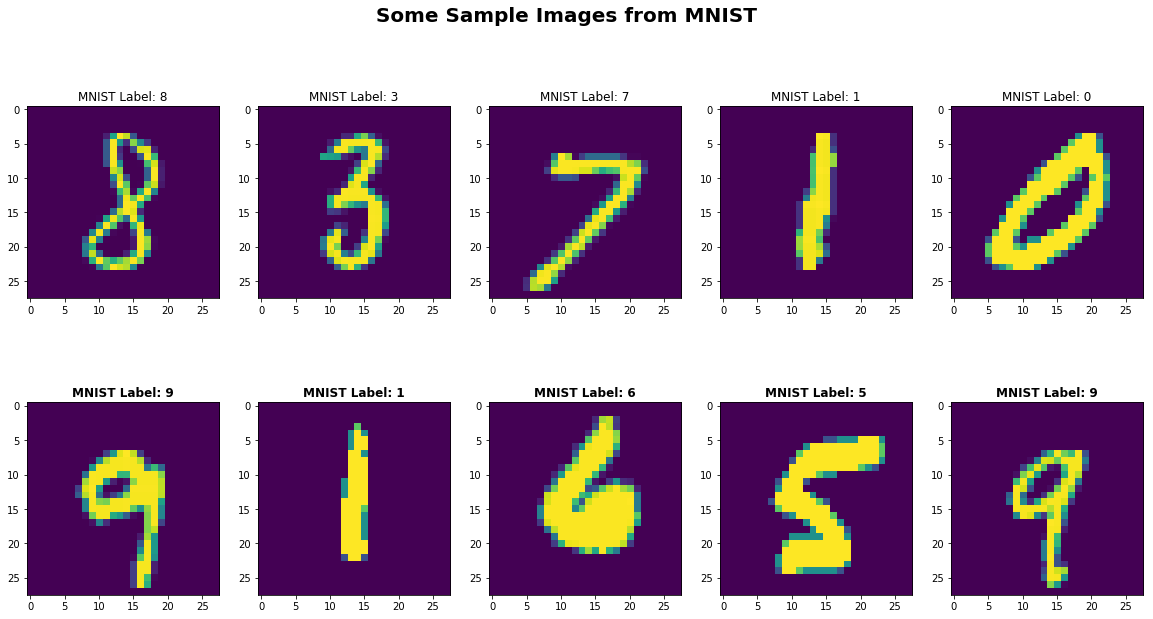

In [14]:
## Define our model 
MLR = Artificial_Neural_Network(LRPyTorch)

## Plot sample images
MLR.viz_training_images()

**1. Using classification accuracy, evaluate how well your model is performing on the validation set at the end of each epoch. Plot this validation accuracy as the model trains.**

Our default parameters for our Artificial Neural Network class are set so that it models Logistic Regression with the batch_size(256), learning rate (0.1), and weight decay/regularization (0.01) as described by the question. 

In [15]:
MLR.fit()

Epoch:  0
Dataset: Validation 
Accuracy: 9031/10000 (90.3%)

Epoch:  1
Dataset: Validation 
Accuracy: 9037/10000 (90.4%)

Epoch:  2
Dataset: Validation 
Accuracy: 9045/10000 (90.5%)

Epoch:  3
Dataset: Validation 
Accuracy: 9030/10000 (90.3%)

Epoch:  4
Dataset: Validation 
Accuracy: 9071/10000 (90.7%)

Epoch:  5
Dataset: Validation 
Accuracy: 9151/10000 (91.5%)

Epoch:  6
Dataset: Validation 
Accuracy: 9076/10000 (90.8%)

Epoch:  7
Dataset: Validation 
Accuracy: 9103/10000 (91.0%)

Epoch:  8
Dataset: Validation 
Accuracy: 9162/10000 (91.6%)

Epoch:  9
Dataset: Validation 
Accuracy: 9134/10000 (91.3%)

Epoch:  10
Dataset: Validation 
Accuracy: 9147/10000 (91.5%)

Epoch:  11
Dataset: Validation 
Accuracy: 9143/10000 (91.4%)

Epoch:  12
Dataset: Validation 
Accuracy: 9090/10000 (90.9%)

Epoch:  13
Dataset: Validation 
Accuracy: 9009/10000 (90.1%)

Epoch:  14
Dataset: Validation 
Accuracy: 9113/10000 (91.1%)

Epoch:  15
Dataset: Validation 
Accuracy: 9046/10000 (90.5%)

Epoch:  16
Dataset

In [16]:
validation_scores = MLR.get_params("validation_scores")

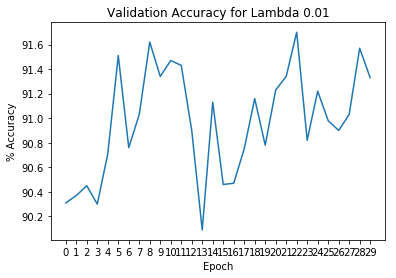

In [17]:
plt.plot(range(len(validation_scores)), validation_scores*100)
plt.title("Validation Accuracy for Lambda {}".format(0.01))
plt.xticks(range(len(validation_scores)))
plt.ylabel('% Accuracy')
plt.xlabel('Epoch')

plt.show()

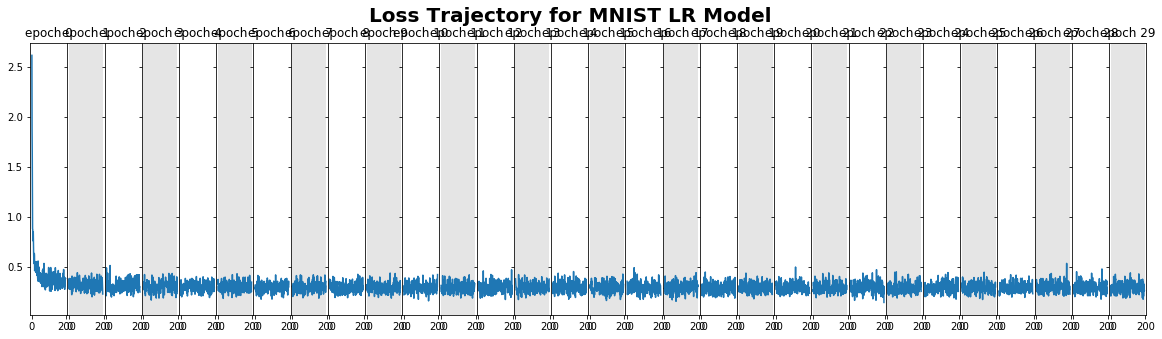

In [18]:
MLR.viz_training_loss()

As we see from both our accuracy scores and the trajectory of our loss functions, after a relatively small number of epochs (1 or 2) the logistic regression stabilizes fairly quickly. While there may be some relatively minor incremental decrease in loss and/or increase in validation accuracy afterwards but the model quickly achieves what seems to be near-peak performance.

**2. Duplicate this plot for some other values of the regularization parameter $\lambda$. When should you stop the training for different values of λ? Give an approximate answer supported by using the plots.**

In [19]:
mlrs = []
accuracies = []
lambdas = [0.001, 0.01, .1, .5]
for lambda_i in lambdas: 
    print("MNIST Logistic Regression -- Lambda {}".format(lambda_i))
    MLR = Artificial_Neural_Network(LRPyTorch,reg_rate=lambda_i)
    MLR.fit(show_validation=False)
    accuracies.append(MLR.get_params("validation_scores"))
    MLR.score(dataset="Validation", save_misclassified=False) 
    mlrs.append(MLR)

MNIST Logistic Regression -- Lambda 0.001
Dataset: Validation 
Accuracy: 9135/10000 (91.3%)

MNIST Logistic Regression -- Lambda 0.01
Dataset: Validation 
Accuracy: 9116/10000 (91.2%)

MNIST Logistic Regression -- Lambda 0.1
Dataset: Validation 
Accuracy: 9202/10000 (92.0%)

MNIST Logistic Regression -- Lambda 0.5
Dataset: Validation 
Accuracy: 8980/10000 (89.8%)



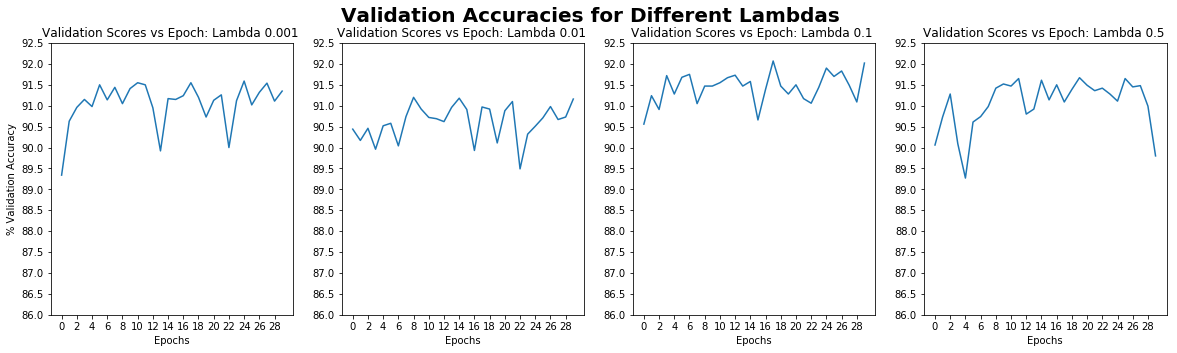

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
plt.suptitle("Validation Accuracies for Different Lambdas", fontsize=20, weight='heavy')
axes[0].set
for i in range(len(accuracies)):
    axes[i].plot(range(len(accuracies[i])), accuracies[i]*100)
    axes[i].set_title("Validation Scores vs Epoch: Lambda {} ".format(lambdas[i]))
    axes[0].set_ylabel("% Validation Accuracy")
    axes[i].set_xlabel("Epochs")
    axes[i].set_xticks(range(0, len(accuracies[i]), 2))
    axes[i].set_yticks([86, 86.5, 87, 87.5, 88.0, 88.5, 89, 89.5, 90, 90.5, 91, 91.5, 92, 92.5])

plt.show()



We see that a regularization rate 0.1 seems to perform the highest, although there doesn't seem to be a big effect for low regularization rates.  High regularization beyond a certain threshold (e.g. 0.5) seems to make the model perform worse.

**3. Select what you consider the best regularization parameter and predict the labels of the test set. Compare with the given labels. What classification accuracy do you obtain on the test set?**

Given the above, let's choose lambda = 0.1 as it seems (to at least nominally) have the highest performance on the validation set.  Let's see how that translates to test set performance.

In [23]:
mlrs[2].score("Test", save_misclassified=True)


Dataset: Test 
Accuracy: 9203/10000 (92.0%)



0.9203

So our expectations are confirmed.  The accuracy is in basically the same ~ 92% (maybe even slightly better than) as the logistic regression without regularization.  So overfitting isn't a major problem but adding a bit of regularization has had a somewhat positive albeit not significant.  Now let's look at the performance of the other models with different regularization parameters on the test set.

In [24]:
mlrs[0].score("Test", save_misclassified=True)
mlrs[2].score("Test", save_misclassified=True)
mlrs[3].score("Test", save_misclassified=True)


Dataset: Test 
Accuracy: 9132/10000 (91.3%)

Dataset: Test 
Accuracy: 9203/10000 (92.0%)

Dataset: Test 
Accuracy: 9063/10000 (90.6%)



0.9063

As we conjectured, all the regularization parameters (in particular in the range we chose) are within approximately same range (91% - 92%) of accuracy on the test set.  Finally let's look at some misclassified images from our selected model.

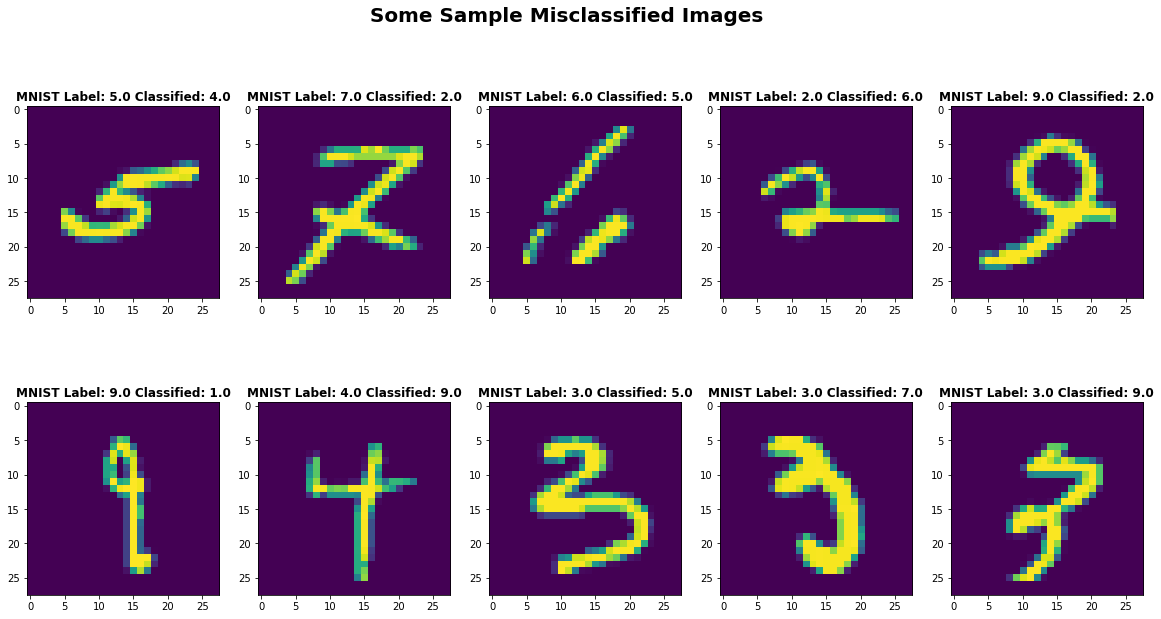

In [25]:
mlrs[2].viz_misclassified_images()

Looking at some misclassified images -- we see that there are a number of 3's and 9's.  A number of the misclassified examples could be considered ambiguous even to a human.

In [26]:
mlrs[2].generate_missed_percentages()

Label: 0 -- Accuracy: 97.85714285714285
Label: 1 -- Accuracy: 97.62114537444934
Label: 2 -- Accuracy: 87.40310077519379
Label: 3 -- Accuracy: 90.3960396039604
Label: 4 -- Accuracy: 91.14052953156822
Label: 5 -- Accuracy: 88.00448430493275
Label: 6 -- Accuracy: 94.67640918580375
Label: 7 -- Accuracy: 90.27237354085604
Label: 8 -- Accuracy: 90.4517453798768
Label: 9 -- Accuracy: 91.67492566897918


Clearly 2's, 3's, 5's, 7's and 8's had poor accuracy compared to the other labeles -- a finding in line with our visual results.

## Problem 3: Multi-Layer Perceptron

The multilayer perceptron can be understood as a logistic regression classifier in which the input is first transformed using a learnt non-linear transformation. The non-linear transformation is usually chosen to be either the logistic function or the $\tanh$ function or the RELU function, and its purpose is to project the data into a space where it becomes linearly separable The output of this so-called hidden layer is then passed to the logistic regression graph that we have constructed in the first problem. 

![](http://deeplearning.net/tutorial/_images/mlp.png)

We'll construct a model with **1 hidden layer**. That is, you will have an input layer with a nonlinearity, then a hidden layer with the nonlinearity, and finally a cross-entropy (or equivalently log-softmax with a log-loss)


Using a similar architecture as in the first part and the same training, validation, and test sets, build a PyTorch model for the multilayer perceptron. Use the $\tanh$ function as the non-linear activation function. 

1. Use $\lambda = 0.001$ to compare with Problem 2. Experiment with the learning rate (try 0.1 and 0.01 for example), batch size (use 20, 50, 100 and 200) and the number of units in your hidden layer (use between 25 and 100 units). For what combination of these parameters do you obtain the highest validation accuracy after a resonable number of epochs that lead to convergence ( start at 10 epochs and play around a bit for convergence)? How does your test accuracy compare to the logistic regression classifier?
2. Try the same values of $\lambda$ you used in Question 2. Does the test set accuracy improve?


*Hint #1:* The initialization of the weights matrix for the hidden layer must assure that the units (neurons) of the perceptron operate in a regime where information gets propagated. For the $\tanh$ function, you may find it advisable to initialize with the interval $[-\sqrt{\frac{6}{fan_{in}+fan_{out}}},\sqrt{\frac{6}{fan_{in}+fan_{out}}}]$, where $fan_{in}$ is the number of units in the $(i-1)$-th layer, and $fan_{out}$ is the number of units in the i-th layer.

*Hint #2*
Train/Validate/Test split can be done in numpy or in PyTorch. Lab will describe a way to do it keeping within the MNIST `DataLoader` workflow: the key is to pass a `SubsetRandomSampler` to `DataLoader`: see the docs.

**Solutions:**

**We'll start with extending our model to exchange out the Logistic Regression model for a full Multi Layer Perceptron model.  As a result of the flexibility and ease of use of PyTorch this should be pretty easy.  Let's take a look. While we specified in the problem that we were looking for *one hidden layer*, as discussed in office hours, piazza, and lab we're willing to accept MLPs with two hidden layers.**

In [27]:
## Our PyTorch implementation of MLP
class MLP(nn.Module):

    ## the constructor is where we'll define all our layers (input, hidden, and output)
    def __init__(self, hidden=50):

        ## this line creates an instance of our parent (or base) class which in this case
        ## is nn.Module.
        super().__init__()

        ## in the lines below we'll create instance variables and assign them torch.nn Models
        ## in order to create our layers.  You should ordinarily have one variable definition for each layer
        ## in your neural network except for the output layer.  The output layer is defined by the number of
        ## outputs in your last layer. Since we're dealing with simple Artificial Neural Networks, we should
        ## predominantly be using nn.Linear.  
        
        ## definee layer1
        self.l1 = nn.Linear(784, hidden)
        
        
        # initialize layer1
        torch.nn.init.xavier_uniform(self.l1.weight)
        torch.nn.init.constant(self.l1.bias, 0.0)
        
        # define layer2
        self.l2 = nn.Linear(hidden,10)

 
    # forwards takes as a parameter x -- the batch of inputs that we want to feed into our neural network model
    # and returns the output of the model ... i.e. the results of the output layer of the model after forward
    # propagation through our model. practically this means you should call each layer you defined in the
    # constructor in sequence plus any activation functions on each layer.
    def forward(self, x):
     
        # call all our layers on our input (in this case we only need one)
        x = self.l1(x)
        x = F.tanh(x)
        x = self.l2(x)

        # Since we're using Cross Entropy Loss
        # we can return our output directly
        return x


**Ok -- that wasn't too bad. We've defined our new MLP with one hidden layer and even included initialization.  In order to compare most closely with the parameters used in Problem 2 (with the exception of the ones specified in the problem), let's start with batch_size = 200, regularization parameter = 0.001 and learning rate = 0.1.  Let's check how the size of the hidden layers affects performance.**

In [36]:

mlps = []
accuracies = []
hiddens = [25, 50, 75, 100]
for hidden_i in hiddens: 
    print("MNIST MLP -- Hidden {}".format(hidden_i))
    mnist_MLP= Artificial_Neural_Network(MLP,reg_rate=0.001,learning_rate=0.1,batch_size=200, hidden=hidden_i)
    mnist_MLP.fit(show_validation=False)
    accuracies.append(mnist_MLP.get_params("validation_scores"))
    mnist_MLP.score(dataset="Validation", save_misclassified=False) 
    mlps.append(mnist_MLP)

MNIST MLP -- Hidden 25
Dataset: Validation 
Accuracy: 9411/10000 (94.1%)

MNIST MLP -- Hidden 50
Dataset: Validation 
Accuracy: 9446/10000 (94.5%)

MNIST MLP -- Hidden 75
Dataset: Validation 
Accuracy: 9523/10000 (95.2%)

MNIST MLP -- Hidden 100
Dataset: Validation 
Accuracy: 9544/10000 (95.4%)



**As you might expect increasing the size of the hidden layers increases the accuracy of the networks.  Some overfitting may ensue, although as we have regularization turned on it may be somewhat muted.  We'll play with the regularization parameter later.  Does batch_size have any effect on accuracy?**

In [37]:
mlps = []
accuracies = []
batches = [50, 100, 200]
for batch in batches: 
    print("MNIST MLP -- Batch Size {}".format(batch))
    mnist_MLP= Artificial_Neural_Network(MLP,reg_rate=0.001,learning_rate=0.1,batch_size=batch, hidden=100)
    mnist_MLP.fit(show_validation=False)
    accuracies.append(mnist_MLP.get_params("validation_scores"))
    mnist_MLP.score(dataset="Validation", save_misclassified=False) 
    mlps.append(MLR)

MNIST MLP -- Batch Size 50
Dataset: Validation 
Accuracy: 9479/10000 (94.8%)

MNIST MLP -- Batch Size 100
Dataset: Validation 
Accuracy: 9521/10000 (95.2%)

MNIST MLP -- Batch Size 200
Dataset: Validation 
Accuracy: 9555/10000 (95.5%)



**It doesn't seem like it has a great effect.  Let's choose the (marginally) best performing batch size of 100 and try to find the optimal learning rate.**

In [38]:
mlps = []
accuracies = []
lrs = [0.001, 0.01, 0.1, 0.5, 1]
for lr in lrs: 
    print("MNIST MLP -- Learning Rate {}".format(lr))
    mnist_MLP= Artificial_Neural_Network(MLP,reg_rate=0.001,learning_rate=lr,batch_size=100, hidden=100)
    mnist_MLP.fit(show_validation=False)
    accuracies.append(mnist_MLP.get_params("validation_scores"))
    mnist_MLP.score(dataset="Validation", save_misclassified=False) 
    mlps.append(mnist_MLP)

MNIST MLP -- Learning Rate 0.001
Dataset: Validation 
Accuracy: 9068/10000 (90.7%)

MNIST MLP -- Learning Rate 0.01
Dataset: Validation 
Accuracy: 9477/10000 (94.8%)

MNIST MLP -- Learning Rate 0.1
Dataset: Validation 
Accuracy: 9535/10000 (95.3%)

MNIST MLP -- Learning Rate 0.5
Dataset: Validation 
Accuracy: 9370/10000 (93.7%)

MNIST MLP -- Learning Rate 1
Dataset: Validation 
Accuracy: 8963/10000 (89.6%)



**It looks like a learning rate of 0.1 is pretty clearly optimal.  As noted earlier, batch size has less effect, but let's use a size of 100 anyway**

In [40]:
mnist_MLP= Artificial_Neural_Network(MLP,reg_rate=0.001,learning_rate=0.1,batch_size=100, hidden=100)
mnist_MLP.fit()

Epoch:  0
Dataset: Validation 
Accuracy: 9278/10000 (92.8%)

Epoch:  1
Dataset: Validation 
Accuracy: 9403/10000 (94.0%)

Epoch:  2
Dataset: Validation 
Accuracy: 9429/10000 (94.3%)

Epoch:  3
Dataset: Validation 
Accuracy: 9462/10000 (94.6%)

Epoch:  4
Dataset: Validation 
Accuracy: 9485/10000 (94.8%)

Epoch:  5
Dataset: Validation 
Accuracy: 9461/10000 (94.6%)

Epoch:  6
Dataset: Validation 
Accuracy: 9467/10000 (94.7%)

Epoch:  7
Dataset: Validation 
Accuracy: 9491/10000 (94.9%)

Epoch:  8
Dataset: Validation 
Accuracy: 9475/10000 (94.8%)

Epoch:  9
Dataset: Validation 
Accuracy: 9501/10000 (95.0%)

Epoch:  10
Dataset: Validation 
Accuracy: 9500/10000 (95.0%)

Epoch:  11
Dataset: Validation 
Accuracy: 9494/10000 (94.9%)

Epoch:  12
Dataset: Validation 
Accuracy: 9490/10000 (94.9%)

Epoch:  13
Dataset: Validation 
Accuracy: 9505/10000 (95.0%)

Epoch:  14
Dataset: Validation 
Accuracy: 9497/10000 (95.0%)

Epoch:  15
Dataset: Validation 
Accuracy: 9479/10000 (94.8%)

Epoch:  16
Dataset

In [41]:
mnist_MLP.score(dataset = "Test")

Dataset: Test 
Accuracy: 9570/10000 (95.7%)



0.957

**Great.  Test set accuracy of ~96%.  Let's try some different regularization rates.**

In [43]:
mlps = []
accuracies = []
lambdas = [0.001, 0.01, .1, .5]
for lambda_i in lambdas: 
    print("MNIST MLP -- Lambda {}".format(lambda_i))
    mnist_MLP= Artificial_Neural_Network(MLP,reg_rate=lambda_i,learning_rate=0.1,batch_size=100, hidden=100)
    mnist_MLP.fit(show_validation=False)
    accuracies.append(mnist_MLP.get_params("validation_scores"))
    mnist_MLP.score(dataset="Validation", save_misclassified=True) 
    mlps.append(mnist_MLP)

MNIST MLP -- Lambda 0.001
Dataset: Validation 
Accuracy: 9501/10000 (95.0%)

MNIST MLP -- Lambda 0.01
Dataset: Validation 
Accuracy: 9480/10000 (94.8%)

MNIST MLP -- Lambda 0.1
Dataset: Validation 
Accuracy: 9532/10000 (95.3%)

MNIST MLP -- Lambda 0.5
Dataset: Validation 
Accuracy: 9513/10000 (95.1%)



**Regularization doesn't seem to have as great an effect on validation set accuracy as you might expect giving that wide MLP's are prone to overfitting.  It looks like we selected a good hidden layer width.  It looks like 0.1 is our best regularization rate, but let's look at test set accuracy for all the candidates.**

In [44]:
for mlp in mlps:
    mlp.score(dataset="Test")

Dataset: Test 
Accuracy: 9558/10000 (95.6%)

Dataset: Test 
Accuracy: 9539/10000 (95.4%)

Dataset: Test 
Accuracy: 9570/10000 (95.7%)

Dataset: Test 
Accuracy: 9558/10000 (95.6%)



It looks like test set accuracies are all in the same range.  95-96% is a good result for a single hidden layer MLP.  If we'd implemented an MLP with 2 hidden layers we might see a result in the 96-97% range.  Convolutional DNN's can get accuracies of 99% and above.

What about classification accuracies?

In [46]:
mlps[1].generate_missed_percentages()

Label: 0 -- Accuracy: 98.57142857142858
Label: 1 -- Accuracy: 98.32599118942731
Label: 2 -- Accuracy: 94.67054263565892
Label: 3 -- Accuracy: 96.53465346534654
Label: 4 -- Accuracy: 94.39918533604887
Label: 5 -- Accuracy: 92.04035874439462
Label: 6 -- Accuracy: 96.76409185803759
Label: 7 -- Accuracy: 93.09338521400778
Label: 8 -- Accuracy: 93.01848049281314
Label: 9 -- Accuracy: 95.8374628344896


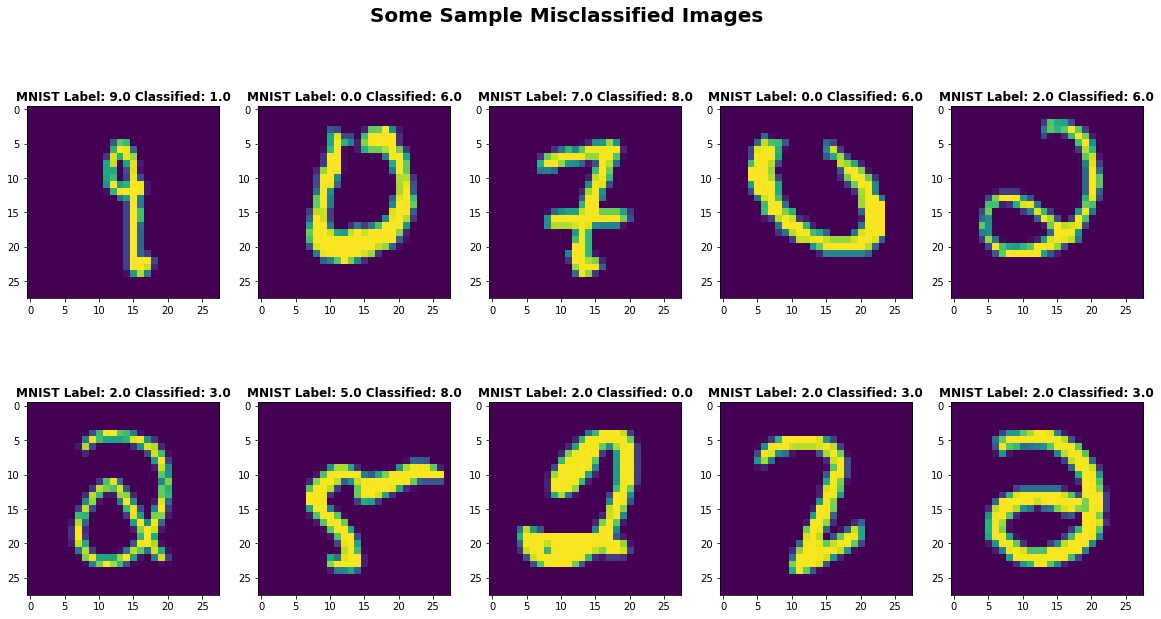

In [87]:
mlps[1].viz_misclassified_images()

**While classification accuracies seem to be higher (and less uneven) than for the logistic regression model, we see that the 2, 4, 7 and 8 labels do a bit worse than other labels in terms of accuracy rates.  Unsurprisingly in our random sample of misclassified images we see a number of 2's.**